In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from kuma_utils.utils import sigmoid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import Ridge

from datasets import *
from transforms import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [46]:
test = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')
valid = pd.read_csv('input/g2net-detecting-continuous-gravitational-waves/v23v.csv')
public748 = pd.read_csv('input/public748.csv')
iafoss_v5160 = {
    'oof': pd.read_csv('input/predictions/val_model_v5_1_6_0.csv'),
    'pred': pd.read_csv('input/predictions/submission_model_v5_1_6_0.csv')}
iafoss_v5210 = {
    'oof': pd.read_csv('input/predictions/val_model_v5_2_1_0.csv'),
    'pred': pd.read_csv('input/predictions/submission_model_v5_2_1_0.csv')}
iafoss_v7000 = {
    'oof': pd.read_csv('input/predictions/val_model_v7_0_0_0.csv'),
    'pred': pd.read_csv('input/predictions/submission_model_v7_0_0_0.csv')}
iafoss_v8000 = {
    'oof': pd.read_csv('input/predictions/val_model_v8_0_0_0c.csv'),
    'pred': pd.read_csv('input/predictions/submission_model_v8_0_0_0c.csv')}
chris_v16 = {
    'oof': pd.read_csv('input/predictions/valset_16_0.7036.csv'),
    'pred': pd.read_csv('input/predictions/sub_16_bce_mse.csv')}
chris_v18 = {
    'oof': pd.read_csv('input/predictions/valset_18_0.6997.csv'),
    'pred': pd.read_csv('input/predictions/sub_18_double_model.csv')}
drhb_exp200 = {
    'oof': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4_EVAL_V23_CORRECT.csv', usecols=['id', 'pred']),
    'pred': pd.read_csv('input/predictions/EXP_200_BASELINE_CASHE_V4.csv')}

In [47]:
valid['is_generated_noise'] = 1 - valid[['nonstationary_H1', 'nonstationary_L1']].max(1)

In [85]:
model_paths = [
    # Path('results/ds_09_val0'),
    # Path('results/ds_09_val1'),
    # Path('results/aug_04'),
    # # Path('results/ds_14'),
    # # Path('results/ds_15'),
    # # Path('results/ds_16'),
    # # Path('results/model_02'),
    # Path('results/ds_14_prep2'),
    # Path('results/ds_17_prep2'),
    # Path('results/ds_18_prep3'),
    # Path('results/ds_18_prep7'),
    # Path('results/ds_18_lf0'),
    Path('results/ds_19'),
    Path('results/ds_19_prep0'),
    Path('results/model_03')
]


In [86]:
prediction_df = {}
oof_df = {}
for p in model_paths:
    pred = sigmoid(np.load(p/'predictions_tta.npy'))
    oof = sigmoid(np.load(p/'outoffolds_tta.npy'))

    if pred.shape[1] == 1:
        pred = pred.reshape(-1)
    elif pred.shape[0] == 5:
        pred = pred[0].reshape(-1)
    prediction_df[p.stem] = pred
    oof_df[p.stem] = oof.reshape(-1)
prediction_df = pd.DataFrame(prediction_df)
prediction_df['id'] = test['id']
# prediction_df['iafoss_v5160'] = iafoss_v5160['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v5210'] = iafoss_v5210['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['iafoss_v7000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
prediction_df['drhb_exp200'] = drhb_exp200['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v16'] = chris_v16['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
# prediction_df['chris_v18'] = chris_v18['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
prediction_df['iafoss_v8000'] = iafoss_v7000['pred'].merge(prediction_df[['id']], on='id', how='right')['target']
oof_df = pd.DataFrame(oof_df)
oof_df['id'] = valid['id']
# oof_df['iafoss_v5160'] = iafoss_v5160['oof']['target']
# oof_df['iafoss_v5210'] = iafoss_v5210['oof']['target']
# oof_df['iafoss_v7000'] = iafoss_v7000['oof']['target']
oof_df['drhb_exp200'] = drhb_exp200['oof']['pred']
# oof_df['chris_v16'] = chris_v16['oof']['target']
# oof_df['chris_v18'] = chris_v18['oof']['target']
oof_df['iafoss_v8000'] = iafoss_v8000['oof']['target']

In [87]:
oof_df['target'] = valid['target']
oof_df.dropna(inplace=True)
oof_df = oof_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

In [88]:
valid['id'] = valid['id'].str[:-4]
prediction_df = prediction_df.merge(valid[['id', 'is_generated_noise']], on='id', how='left')

In [89]:
oof_df

,ds_19,ds_19_prep0,model_03,id,drhb_exp200,iafoss_v8000,target,is_generated_noise
0,0.437987,0.417616,0.469050,00054,0.265349,0.484375,0,1
1,0.481549,0.469458,0.518737,00072,0.297389,0.525391,1,1
2,0.537548,0.544146,0.531273,00076,0.421611,0.560059,0,1
3,1.000000,0.999980,0.999999,00134,0.999995,0.987793,1,1
4,0.452154,0.448764,0.430400,001a5,0.244278,0.454834,0,1
...,...,...,...,...,...,...,...,...
8040,0.999998,0.999966,1.000000,ffbce,0.999996,0.980957,1,1
8041,0.479864,0.463732,0.534222,ffc2d,0.300561,0.491455,0,1
8042,0.402699,0.408307,0.419820,ffc90,0.246879,0.454346,1,1
8043,0.999315,0.998771,0.993517,ffe27,0.999998,0.499023,1,1


In [90]:
prediction_df

,ds_19,ds_19_prep0,model_03,id,drhb_exp200,iafoss_v8000,is_generated_noise
0,0.421400,0.429352,0.455823,00054c878,0.356428,0.513184,NaN
1,0.999384,0.998229,0.959431,0007285a3,0.999973,0.991699,NaN
2,0.402242,0.401538,0.428347,00076c5a6,0.268465,0.432129,NaN
3,0.777102,0.824376,0.967586,001349290,0.779437,0.781738,NaN
4,0.830524,0.883289,0.989925,001a52e92,0.997136,0.987793,NaN
...,...,...,...,...,...,...,...
7970,0.999999,0.999998,0.999858,ffbce04ef,0.999996,0.999512,NaN
7971,0.528727,0.524964,0.559962,ffc2d976b,0.420342,0.608887,NaN
7972,0.436106,0.426501,0.449506,ffc905909,0.213687,0.475098,NaN
7973,0.415357,0.418603,0.473539,ffe276f3e,0.271413,0.550293,NaN


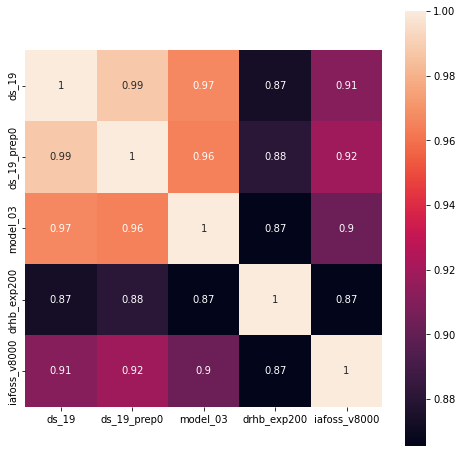

In [91]:
plt.figure(figsize=(8, 8))
sns.heatmap(prediction_df.drop('is_generated_noise', axis=1).corr(), square=True, annot=True)
plt.show()

In [93]:
model = Ridge(positive=True)
X = oof_df.drop(['target', 'id', 'is_generated_noise'], axis=1)
y = oof_df['target']
X_test = prediction_df.drop(['id', 'is_generated_noise'], axis=1)
model.fit(X, y)
y_pred = model.predict(X)
y_stack = model.predict(X_test)
print('stacking cv', roc_auc_score(y, y_pred))
print('weight', model.coef_)

stacking cv 0.7865842887777241
weight [0.2930412  0.25249875 0.34038538 0.         0.14893125]


In [60]:
y_stack

array([0.44781037, 1.0024174 , 0.41366293, ..., 0.44311507, 0.45460892,
       0.43660121])

In [82]:
test['target'] = prediction_df['model_03']
# test['target'] = y_stack

In [83]:
test

,id,target
0,00054c878,0.455823
1,0007285a3,0.959431
2,00076c5a6,0.428347
3,001349290,0.967586
4,001a52e92,0.989925
...,...,...
7970,ffbce04ef,0.999858
7971,ffc2d976b,0.559962
7972,ffc905909,0.449506
7973,ffe276f3e,0.473539


In [70]:
oof_df

,ds_19,ds_19_prep0,model_03,id,drhb_exp200,iafoss_v8000,target,is_generated_noise
0,0.437987,0.417616,0.469050,00054c878_gen,0.265349,0.484375,0,1
1,0.481549,0.469458,0.518737,0007285a3_gen,0.297389,0.525391,1,1
2,0.537548,0.544146,0.531273,00076c5a6_gen,0.421611,0.560059,0,1
3,1.000000,0.999980,0.999999,001349290_gen,0.999995,0.987793,1,1
4,0.452154,0.448764,0.430400,001a52e92_gen,0.244278,0.454834,0,1
...,...,...,...,...,...,...,...,...
7966,0.999998,0.999966,1.000000,ffbce04ef_gen,0.999996,0.980957,1,1
7967,0.479864,0.463732,0.534222,ffc2d976b_gen,0.300561,0.491455,0,1
7968,0.402699,0.408307,0.419820,ffc905909_gen,0.246879,0.454346,1,1
7969,0.999315,0.998771,0.993517,ffe276f3e_gen,0.999998,0.499023,1,1


In [94]:
X.columns

Index(['ds_19', 'ds_19_prep0', 'model_03', 'drhb_exp200', 'iafoss_v8000'], dtype='object')

In [65]:
name = '_'.join(X.columns)

In [84]:
# test.to_csv(f'results/stacking_{name}.csv', index=False)
test.to_csv(Path('results/model_03')/'submission.csv', index=False)

# Trad blending

In [15]:
blend_df = dict(
    # COMB7=pd.read_csv('input/predictions/COMB_7.csv')['target'], # LB 0.771
    # stacking_res=y_stack, # stack with only my model cv 0.739
    # drhb_exp200=prediction_df['drhb_exp200'], # LB 0.754 (add because it has no CV/LB corr)
    # iafoss_5160=prediction_df['iafoss_v5160'], # LB 0.758
    # iafoss_5210=prediction_df['iafoss_v5210'], # LB 0.757
    # public761=pd.read_csv('input/public761.csv')['target']
    COMB13_RB=pd.read_csv('input/predictions/COMB_13_REAL_BLENDING_0.4_0.6.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep2=pd.read_csv('results/ds_17_prep2/submission.csv').merge(test['id'], on='id', how='right')['target'],
    # ds_17_prep1=pd.read_csv('results/ds_17_prep1_beforefix/submission.csv').merge(test['id'], on='id', how='right')['target'],
    ds_18_prep3=pd.read_csv('results/ds_18_prep3/submission.csv').merge(test['id'], on='id', how='right')['target'],
    ds_18_prep7=pd.read_csv('results/ds_18_prep7/submission.csv').merge(test['id'], on='id', how='right')['target'],
)
blend_df = pd.DataFrame(blend_df)
blend_df = blend_df.rank(axis=0)
blend_df = blend_df / blend_df.max(axis=0).values[None, :]

In [16]:
blend_df.corr()

,COMB13_RB,ds_18_prep3,ds_18_prep7
COMB13_RB,1.000000,0.843587,0.839268
ds_18_prep3,0.843587,1.000000,0.954660
ds_18_prep7,0.839268,0.954660,1.000000


In [28]:
blend_df['target'] = \
    blend_df['COMB13_RB'] * 0.8 + blend_df['ds_17_prep2'] * 0.1 + blend_df['ds_17_prep1'] * 0.1

In [29]:
test['target'] = blend_df['target']
test.to_csv(Path('results/blend_comb13rb_ds17prep2_ds17prep1.csv'), index=False)